# https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc Dataset - EDA
## https://disk.360.yandex.ru/d/3h6sT_o1ZYhT1A - он же на пошаренном яндекс диске, лучше забирать из него

## 1. Setup and Imports

In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import seaborn as sns
from PIL import Image
import cv2

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Dataset

In [2]:
data_dir = Path('/home/dxdxxd/projects/dataIntegratorSoccer/03_exports/yolo_small_export/coco')
img_dir = data_dir / 'data'

datasets = {}
for split in ['train', 'valid', 'test']:
    with open(data_dir / f'{split}' / f'labels.json') as f:
        datasets[split] = json.load(f)
    print(f"{split}: {len(datasets[split]['images'])} images, {len(datasets[split]['annotations'])} annotations")

coco_data = datasets['train']
IMG_WIDTH = coco_data['images'][0]['width']
IMG_HEIGHT = coco_data['images'][0]['height']
print(f"Image size: {IMG_WIDTH}x{IMG_HEIGHT}")

train: 275 images, 6591 annotations
valid: 56 images, 1339 annotations
test: 41 images, 976 annotations
Image size: 1920x1080


## 3. Dataset Overview

In [3]:
print(f"Version: {coco_data['info']['version']}")
print(f"Categories: {', '.join([cat['name'] for cat in coco_data['categories']])}")

for split, data in datasets.items():
    n_imgs, n_anns = len(data['images']), len(data['annotations'])
    print(f"{split}: {n_imgs:,} images, {n_anns:,} annotations ({n_anns/n_imgs:.1f} per image)")

Version: 
Categories: player, goalkeeper, referee, ball
train: 275 images, 6,591 annotations (24.0 per image)
valid: 56 images, 1,339 annotations (23.9 per image)
test: 41 images, 976 annotations (23.8 per image)


## 4. Category Distribution

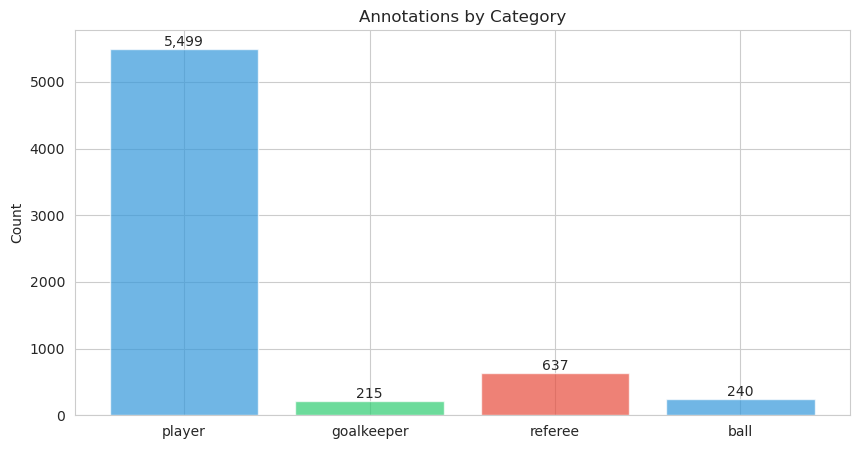

player: 5,499 (83.4%)
goalkeeper: 215 (3.3%)
referee: 637 (9.7%)
ball: 240 (3.6%)


In [4]:
category_counts = Counter([ann['category_id'] for ann in coco_data['annotations']])
category_names = {cat['id']: cat['name'] for cat in coco_data['categories']}

categories = [category_names[cid] for cid in sorted(category_counts.keys())]
counts = [category_counts[cid] for cid in sorted(category_counts.keys())]

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c']
ax.bar(categories, counts, color=colors, alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Annotations by Category')
for i, count in enumerate(counts):
    ax.text(i, count, f'{count:,}', ha='center', va='bottom')
plt.show()

for cat_id in sorted(category_counts.keys()):
    count = category_counts[cat_id]
    pct = count / len(coco_data['annotations']) * 100
    print(f"{category_names[cat_id]}: {count:,} ({pct:.1f}%)")

## 5. Bounding Box Analysis

### Cell 1: Human Classes Analysis (Player, Goalkeeper, Referee)


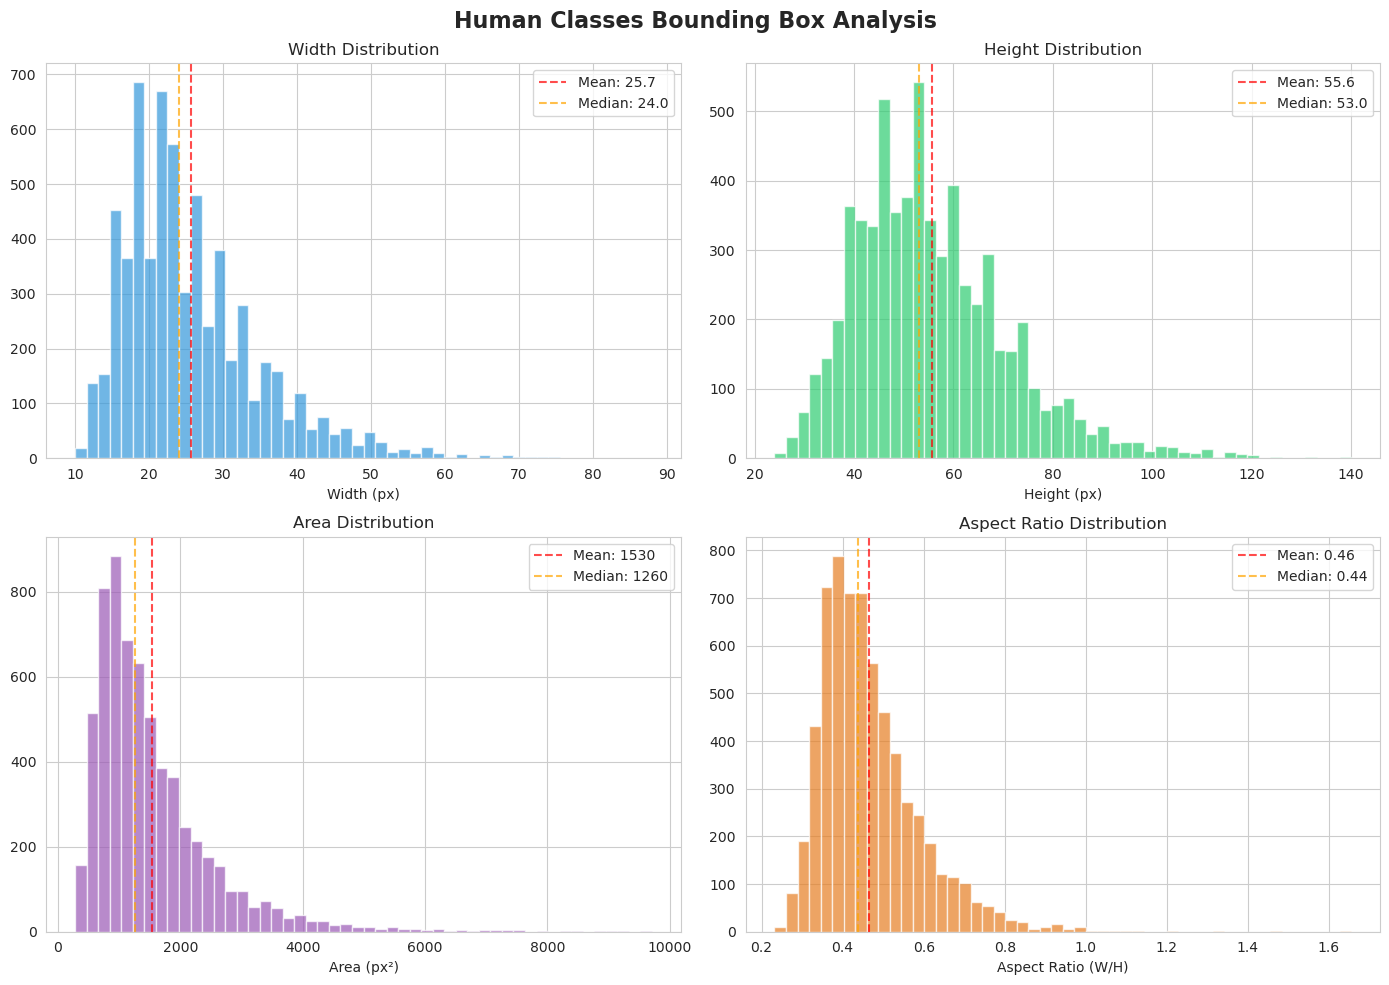

Human Classes Statistics:
Count: 6351 annotations
Width: 25.7±9.4 px
Height: 55.6±15.6 px
Area: 1530±996 px²
Aspect ratio: 0.46±0.12


In [5]:
# Human classes bbox analysis
human_category_ids = [cat['id'] for cat in coco_data['categories'] 
                      if cat['name'] in ['player', 'goalkeeper', 'referee']]

human_bbox_widths = []
human_bbox_heights = []
human_bbox_areas = []
human_bbox_aspect_ratios = []

for ann in coco_data['annotations']:
    if ann['category_id'] in human_category_ids:
        bbox = ann['bbox']
        w, h = bbox[2], bbox[3]
        human_bbox_widths.append(w)
        human_bbox_heights.append(h)
        human_bbox_areas.append(ann['area'])
        human_bbox_aspect_ratios.append(w / h if h > 0 else 0)

human_bbox_widths = np.array(human_bbox_widths)
human_bbox_heights = np.array(human_bbox_heights)
human_bbox_areas = np.array(human_bbox_areas)
human_bbox_aspect_ratios = np.array(human_bbox_aspect_ratios)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Human Classes Bounding Box Analysis', fontsize=16, fontweight='bold')

axes[0, 0].hist(human_bbox_widths, bins=50, alpha=0.7, color='#3498db')
axes[0, 0].axvline(np.mean(human_bbox_widths), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_bbox_widths):.1f}')
axes[0, 0].axvline(np.median(human_bbox_widths), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_bbox_widths):.1f}')
axes[0, 0].set_xlabel('Width (px)')
axes[0, 0].set_title('Width Distribution')
axes[0, 0].legend()

axes[0, 1].hist(human_bbox_heights, bins=50, alpha=0.7, color='#2ecc71')
axes[0, 1].axvline(np.mean(human_bbox_heights), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_bbox_heights):.1f}')
axes[0, 1].axvline(np.median(human_bbox_heights), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_bbox_heights):.1f}')
axes[0, 1].set_xlabel('Height (px)')
axes[0, 1].set_title('Height Distribution')
axes[0, 1].legend()

axes[1, 0].hist(human_bbox_areas, bins=50, alpha=0.7, color='#9b59b6')
axes[1, 0].axvline(np.mean(human_bbox_areas), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_bbox_areas):.0f}')
axes[1, 0].axvline(np.median(human_bbox_areas), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_bbox_areas):.0f}')
axes[1, 0].set_xlabel('Area (px²)')
axes[1, 0].set_title('Area Distribution')
axes[1, 0].legend()

axes[1, 1].hist(human_bbox_aspect_ratios, bins=50, alpha=0.7, color='#e67e22')
axes[1, 1].axvline(np.mean(human_bbox_aspect_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_bbox_aspect_ratios):.2f}')
axes[1, 1].axvline(np.median(human_bbox_aspect_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_bbox_aspect_ratios):.2f}')
axes[1, 1].set_xlabel('Aspect Ratio (W/H)')
axes[1, 1].set_title('Aspect Ratio Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Human Classes Statistics:")
print(f"Count: {len(human_bbox_widths)} annotations")
print(f"Width: {np.mean(human_bbox_widths):.1f}±{np.std(human_bbox_widths):.1f} px")
print(f"Height: {np.mean(human_bbox_heights):.1f}±{np.std(human_bbox_heights):.1f} px")
print(f"Area: {np.mean(human_bbox_areas):.0f}±{np.std(human_bbox_areas):.0f} px²")
print(f"Aspect ratio: {np.mean(human_bbox_aspect_ratios):.2f}±{np.std(human_bbox_aspect_ratios):.2f}")

#### Человечки еще меньше

### Cell 2: Ball Class Analysis


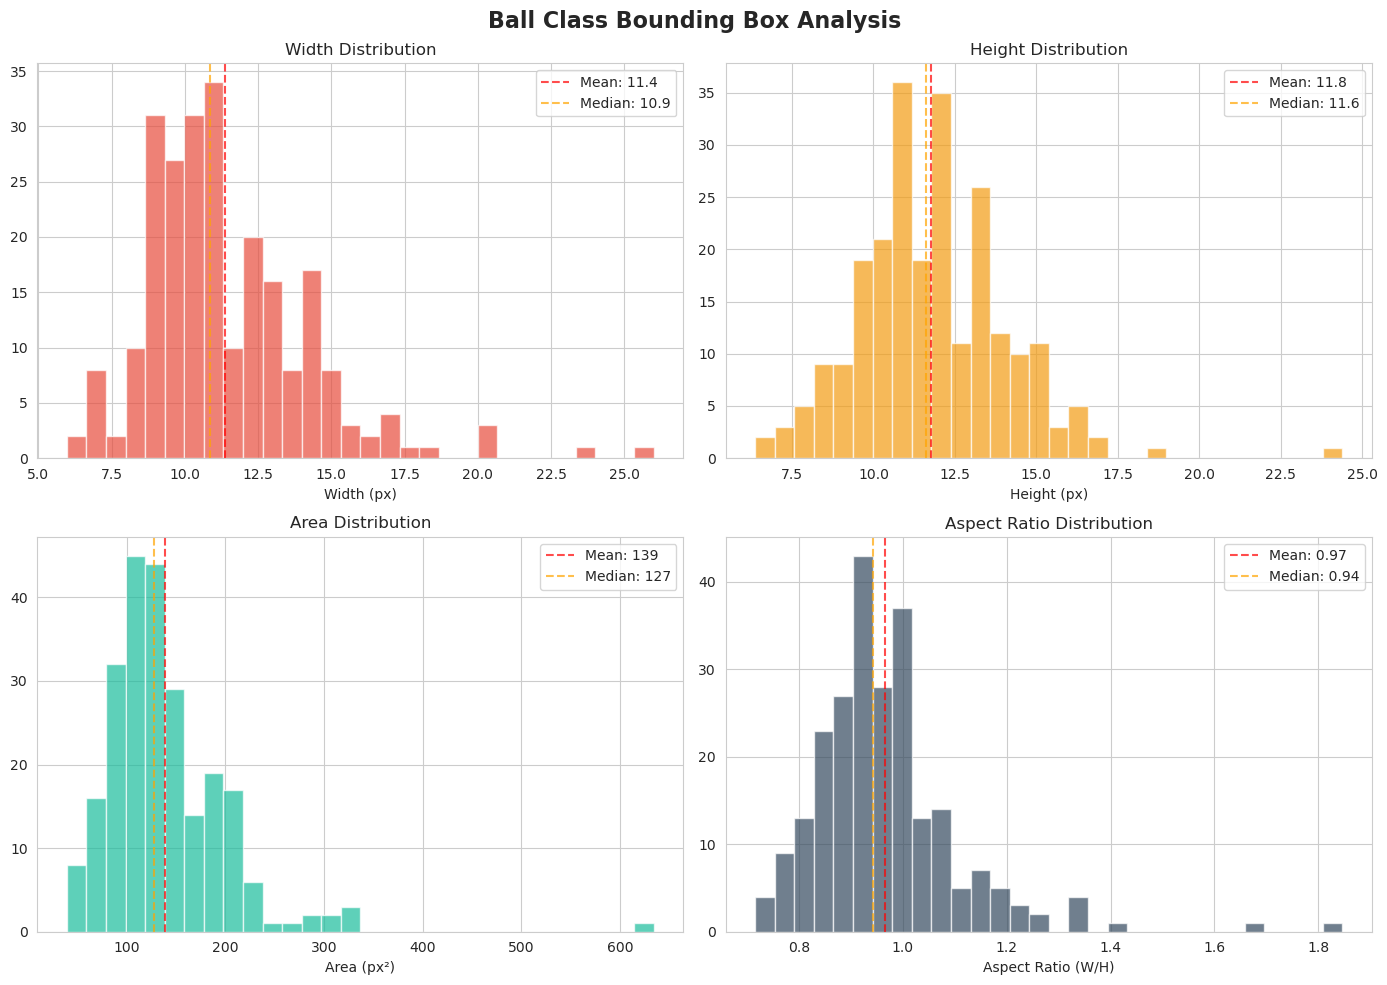

Ball Class Statistics:
Count: 240 annotations
Width: 11.4±2.8 px
Height: 11.8±2.3 px
Area: 139±62 px²
Aspect ratio: 0.97±0.14


In [6]:
# Ball class bbox analysis
ball_category_ids = [cat['id'] for cat in coco_data['categories'] 
                     if cat['name'] == 'ball']

ball_bbox_widths = []
ball_bbox_heights = []
ball_bbox_areas = []
ball_bbox_aspect_ratios = []

for ann in coco_data['annotations']:
    if ann['category_id'] in ball_category_ids:
        bbox = ann['bbox']
        w, h = bbox[2], bbox[3]
        ball_bbox_widths.append(w)
        ball_bbox_heights.append(h)
        ball_bbox_areas.append(ann['area'])
        ball_bbox_aspect_ratios.append(w / h if h > 0 else 0)

ball_bbox_widths = np.array(ball_bbox_widths)
ball_bbox_heights = np.array(ball_bbox_heights)
ball_bbox_areas = np.array(ball_bbox_areas)
ball_bbox_aspect_ratios = np.array(ball_bbox_aspect_ratios)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Ball Class Bounding Box Analysis', fontsize=16, fontweight='bold')

axes[0, 0].hist(ball_bbox_widths, bins=30, alpha=0.7, color='#e74c3c')
axes[0, 0].axvline(np.mean(ball_bbox_widths), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_bbox_widths):.1f}')
axes[0, 0].axvline(np.median(ball_bbox_widths), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_bbox_widths):.1f}')
axes[0, 0].set_xlabel('Width (px)')
axes[0, 0].set_title('Width Distribution')
axes[0, 0].legend()

axes[0, 1].hist(ball_bbox_heights, bins=30, alpha=0.7, color='#f39c12')
axes[0, 1].axvline(np.mean(ball_bbox_heights), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_bbox_heights):.1f}')
axes[0, 1].axvline(np.median(ball_bbox_heights), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_bbox_heights):.1f}')
axes[0, 1].set_xlabel('Height (px)')
axes[0, 1].set_title('Height Distribution')
axes[0, 1].legend()

axes[1, 0].hist(ball_bbox_areas, bins=30, alpha=0.7, color='#1abc9c')
axes[1, 0].axvline(np.mean(ball_bbox_areas), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_bbox_areas):.0f}')
axes[1, 0].axvline(np.median(ball_bbox_areas), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_bbox_areas):.0f}')
axes[1, 0].set_xlabel('Area (px²)')
axes[1, 0].set_title('Area Distribution')
axes[1, 0].legend()

axes[1, 1].hist(ball_bbox_aspect_ratios, bins=30, alpha=0.7, color='#34495e')
axes[1, 1].axvline(np.mean(ball_bbox_aspect_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_bbox_aspect_ratios):.2f}')
axes[1, 1].axvline(np.median(ball_bbox_aspect_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_bbox_aspect_ratios):.2f}')
axes[1, 1].set_xlabel('Aspect Ratio (W/H)')
axes[1, 1].set_title('Aspect Ratio Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Ball Class Statistics:")
print(f"Count: {len(ball_bbox_widths)} annotations")
print(f"Width: {np.mean(ball_bbox_widths):.1f}±{np.std(ball_bbox_widths):.1f} px")
print(f"Height: {np.mean(ball_bbox_heights):.1f}±{np.std(ball_bbox_heights):.1f} px")
print(f"Area: {np.mean(ball_bbox_areas):.0f}±{np.std(ball_bbox_areas):.0f} px²")
print(f"Aspect ratio: {np.mean(ball_bbox_aspect_ratios):.2f}±{np.std(ball_bbox_aspect_ratios):.2f}")

#### Мяч совсем маленький

## 5.1. Object Location Analysis (Heatmap)

### Human Classes Heatmap


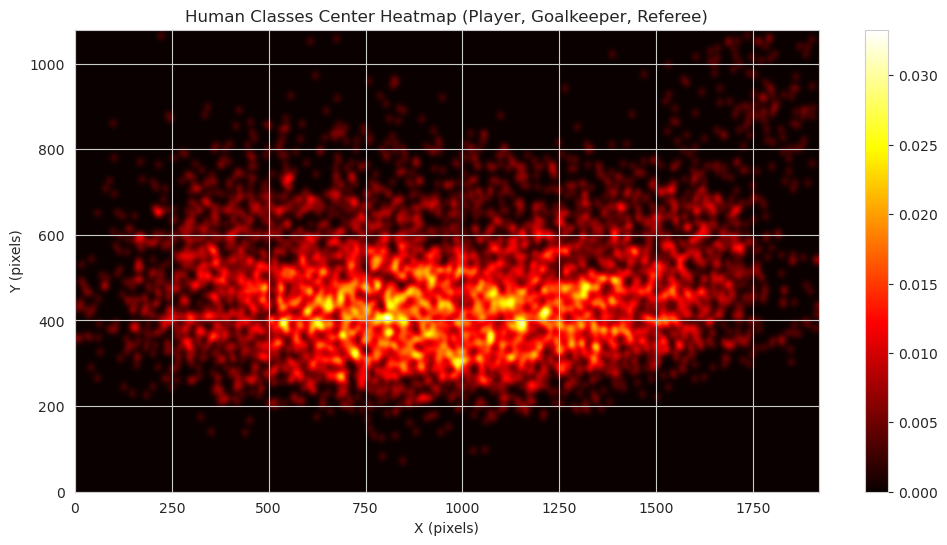

Peak density at y=450 (42% from top)
Top: 72.5%, Bottom: 27.5%


In [7]:
# Human classes heatmap
human_category_ids = [cat['id'] for cat in coco_data['categories'] 
                      if cat['name'] in ['player', 'goalkeeper', 'referee']]

human_heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

for ann in coco_data['annotations']:
    if ann['category_id'] in human_category_ids:
        bbox = ann['bbox']
        cx = int(bbox[0] + bbox[2] / 2)
        cy = int(bbox[1] + bbox[3] / 2)
        cx = np.clip(cx, 0, IMG_WIDTH - 1)
        cy = np.clip(cy, 0, IMG_HEIGHT - 1)
        human_heatmap[cy, cx] += 1

human_heatmap_smoothed = cv2.GaussianBlur(human_heatmap, (51, 51), 0)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(human_heatmap_smoothed, cmap='hot', aspect='auto')
ax.set_title('Human Classes Center Heatmap (Player, Goalkeeper, Referee)')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

vertical_dist = np.sum(human_heatmap, axis=1)
peak_y = np.argmax(vertical_dist)
print(f"Peak density at y={peak_y} ({peak_y/IMG_HEIGHT*100:.0f}% from top)")

top_half = np.sum(human_heatmap[:IMG_HEIGHT//2, :])
bottom_half = np.sum(human_heatmap[IMG_HEIGHT//2:, :])
print(f"Top: {top_half/(top_half+bottom_half)*100:.1f}%, Bottom: {bottom_half/(top_half+bottom_half)*100:.1f}%")

#### Видимо, мы уже хорошо понимаем, как выглядит типичная хитмапа футбольного матча - ничего нового

### Ball Class Heatmap


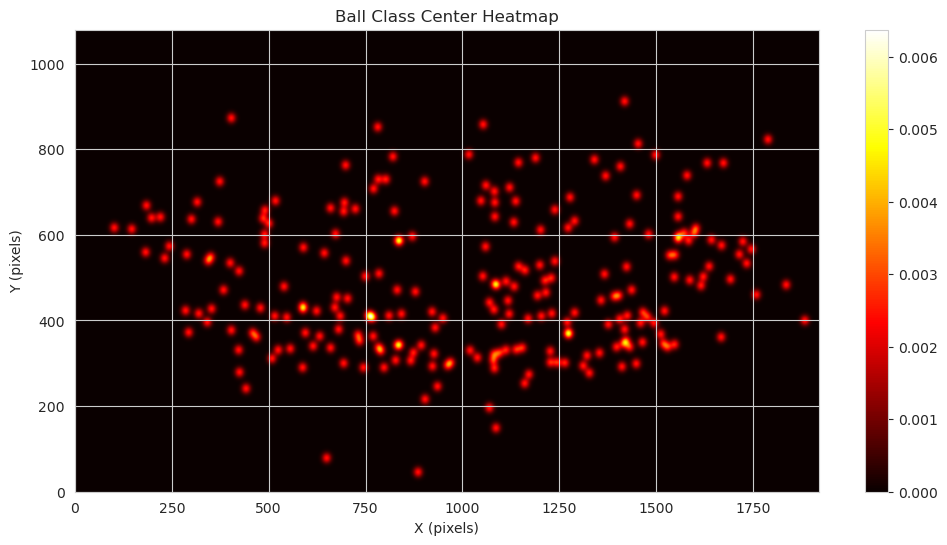

Peak density at y=290 (27% from top)
Top: 64.2%, Bottom: 35.8%


In [8]:
# Ball class heatmap
ball_category_ids = [cat['id'] for cat in coco_data['categories'] 
                     if cat['name'] == 'ball']

ball_heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

for ann in coco_data['annotations']:
    if ann['category_id'] in ball_category_ids:
        bbox = ann['bbox']
        cx = int(bbox[0] + bbox[2] / 2)
        cy = int(bbox[1] + bbox[3] / 2)
        cx = np.clip(cx, 0, IMG_WIDTH - 1)
        cy = np.clip(cy, 0, IMG_HEIGHT - 1)
        ball_heatmap[cy, cx] += 1

ball_heatmap_smoothed = cv2.GaussianBlur(ball_heatmap, (51, 51), 0)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(ball_heatmap_smoothed, cmap='hot', aspect='auto')
ax.set_title('Ball Class Center Heatmap')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

vertical_dist = np.sum(ball_heatmap, axis=1)
peak_y = np.argmax(vertical_dist)
print(f"Peak density at y={peak_y} ({peak_y/IMG_HEIGHT*100:.0f}% from top)")

top_half = np.sum(ball_heatmap[:IMG_HEIGHT//2, :])
bottom_half = np.sum(ball_heatmap[IMG_HEIGHT//2:, :])
print(f"Top: {top_half/(top_half+bottom_half)*100:.1f}%, Bottom: {bottom_half/(top_half+bottom_half)*100:.1f}%")

## 5.2. Bounding Box to Frame Area Ratio Analysis

### Human Classes Area Ratio Analysis

/tmp/ipykernel_75248/2561287722.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=[cat.capitalize() for cat in sorted(human_area_ratios_by_category.keys())])


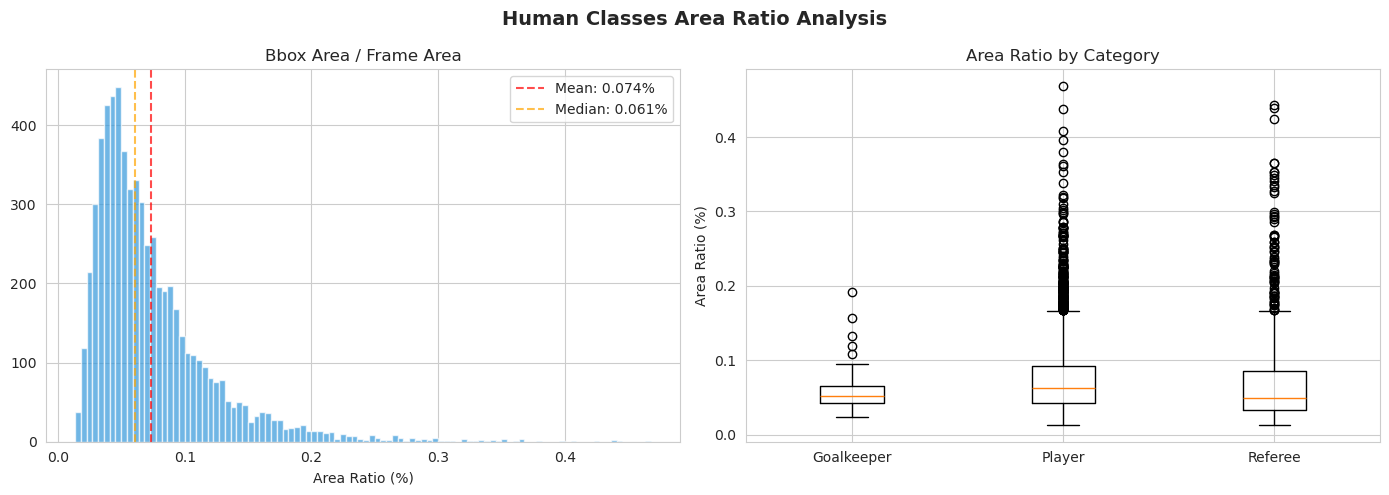

Human Classes Area Ratio Statistics:
Mean: 0.074%, Median: 0.061%
Range: 0.0135% - 0.468%
Percentiles: 50th=0.061%, 95th=0.166%


In [9]:
# Human classes area ratio analysis
human_category_ids = [cat['id'] for cat in coco_data['categories'] 
                      if cat['name'] in ['player', 'goalkeeper', 'referee']]

frame_area = IMG_WIDTH * IMG_HEIGHT
human_area_ratios = []
human_area_ratios_by_category = defaultdict(list)

for ann in coco_data['annotations']:
    if ann['category_id'] in human_category_ids:
        ratio = ann['area'] / frame_area * 100
        human_area_ratios.append(ratio)
        cat_name = category_names[ann['category_id']]
        human_area_ratios_by_category[cat_name].append(ratio)

human_area_ratios = np.array(human_area_ratios)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Human Classes Area Ratio Analysis', fontsize=14, fontweight='bold')

axes[0].hist(human_area_ratios, bins=100, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(human_area_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_area_ratios):.3f}%')
axes[0].axvline(np.median(human_area_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_area_ratios):.3f}%')
axes[0].set_xlabel('Area Ratio (%)')
axes[0].set_title('Bbox Area / Frame Area')
axes[0].legend()

data = [human_area_ratios_by_category[cat] for cat in sorted(human_area_ratios_by_category.keys())]
axes[1].boxplot(data, labels=[cat.capitalize() for cat in sorted(human_area_ratios_by_category.keys())])
axes[1].set_ylabel('Area Ratio (%)')
axes[1].set_title('Area Ratio by Category')

plt.tight_layout()
plt.show()

print("Human Classes Area Ratio Statistics:")
print(f"Mean: {np.mean(human_area_ratios):.3f}%, Median: {np.median(human_area_ratios):.3f}%")
print(f"Range: {np.min(human_area_ratios):.4f}% - {np.max(human_area_ratios):.3f}%")
print(f"Percentiles: 50th={np.percentile(human_area_ratios, 50):.3f}%, 95th={np.percentile(human_area_ratios, 95):.3f}%")

### Ball Class Area Ratio Analysis

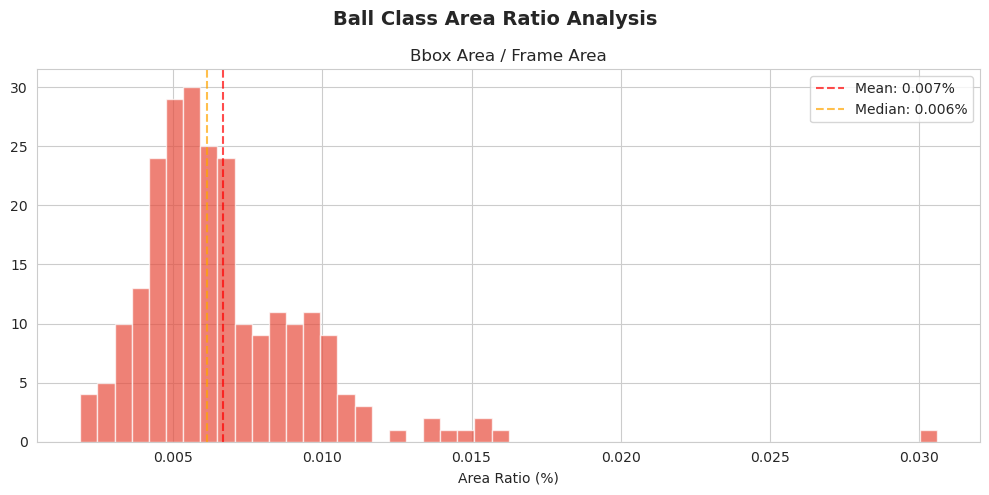

Ball Class Area Ratio Statistics:
Mean: 0.007%, Median: 0.006%
Range: 0.0019% - 0.031%
Percentiles: 50th=0.006%, 95th=0.011%


In [10]:
# Ball class area ratio analysis
ball_category_ids = [cat['id'] for cat in coco_data['categories'] 
                     if cat['name'] == 'ball']

frame_area = IMG_WIDTH * IMG_HEIGHT
ball_area_ratios = []

for ann in coco_data['annotations']:
    if ann['category_id'] in ball_category_ids:
        ratio = ann['area'] / frame_area * 100
        ball_area_ratios.append(ratio)

ball_area_ratios = np.array(ball_area_ratios)

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Ball Class Area Ratio Analysis', fontsize=14, fontweight='bold')

ax.hist(ball_area_ratios, bins=50, alpha=0.7, color='#e74c3c')
ax.axvline(np.mean(ball_area_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_area_ratios):.3f}%')
ax.axvline(np.median(ball_area_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_area_ratios):.3f}%')
ax.set_xlabel('Area Ratio (%)')
ax.set_title('Bbox Area / Frame Area')
ax.legend()

plt.tight_layout()
plt.show()

print("Ball Class Area Ratio Statistics:")
print(f"Mean: {np.mean(ball_area_ratios):.3f}%, Median: {np.median(ball_area_ratios):.3f}%")
print(f"Range: {np.min(ball_area_ratios):.4f}% - {np.max(ball_area_ratios):.3f}%")
print(f"Percentiles: 50th={np.percentile(ball_area_ratios, 50):.3f}%, 95th={np.percentile(ball_area_ratios, 95):.3f}%")

### Human Classes Relative Size Analysis


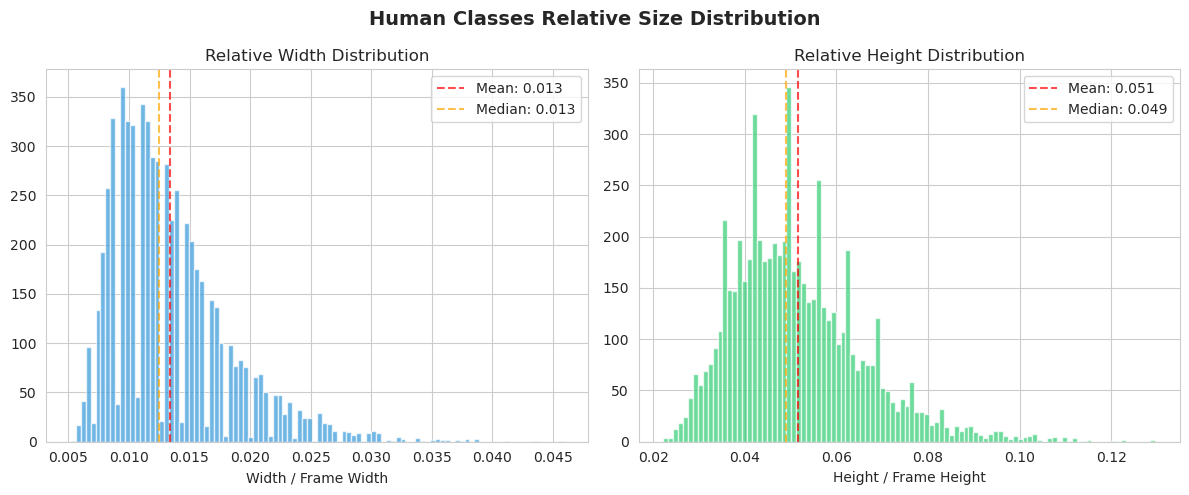

Human Classes Relative Size Statistics:
Width:  mean=0.013, median=0.013
Height: mean=0.051, median=0.049


In [11]:
# Human classes relative size analysis
human_category_ids = [cat['id'] for cat in coco_data['categories'] 
                      if cat['name'] in ['player', 'goalkeeper', 'referee']]

human_width_ratios = []
human_height_ratios = []

for ann in coco_data['annotations']:
    if ann['category_id'] in human_category_ids:
        bbox = ann['bbox']
        human_width_ratios.append(bbox[2] / IMG_WIDTH)
        human_height_ratios.append(bbox[3] / IMG_HEIGHT)

human_width_ratios = np.array(human_width_ratios)
human_height_ratios = np.array(human_height_ratios)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Human Classes Relative Size Distribution', fontsize=14, fontweight='bold')

axes[0].hist(human_width_ratios, bins=100, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(human_width_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_width_ratios):.3f}')
axes[0].axvline(np.median(human_width_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_width_ratios):.3f}')
axes[0].set_xlabel('Width / Frame Width')
axes[0].set_title('Relative Width Distribution')
axes[0].legend()

axes[1].hist(human_height_ratios, bins=100, alpha=0.7, color='#2ecc71')
axes[1].axvline(np.mean(human_height_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(human_height_ratios):.3f}')
axes[1].axvline(np.median(human_height_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(human_height_ratios):.3f}')
axes[1].set_xlabel('Height / Frame Height')
axes[1].set_title('Relative Height Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Human Classes Relative Size Statistics:")
print(f"Width:  mean={np.mean(human_width_ratios):.3f}, median={np.median(human_width_ratios):.3f}")
print(f"Height: mean={np.mean(human_height_ratios):.3f}, median={np.median(human_height_ratios):.3f}")

### Ball Class Relative Size Analysis

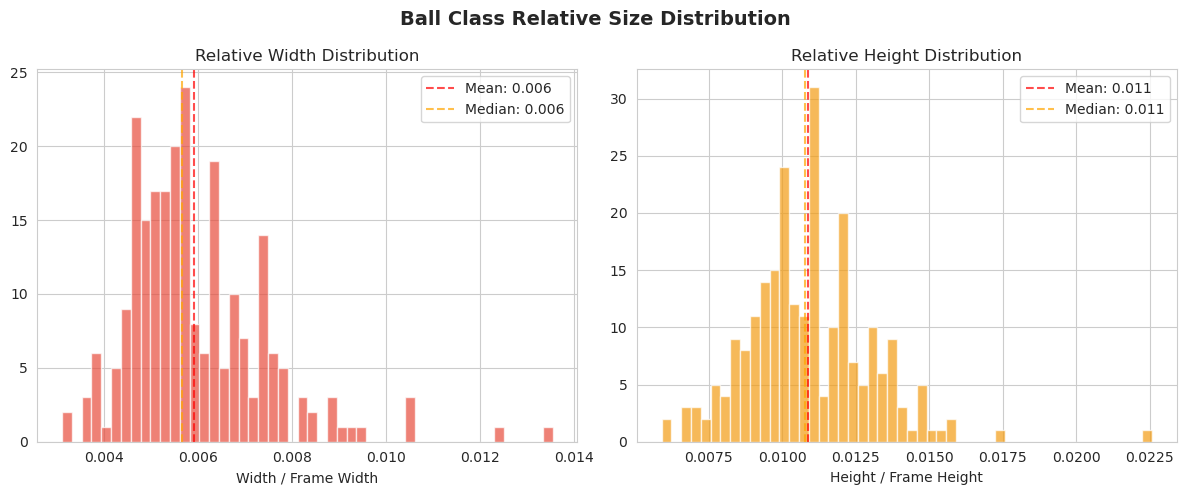

Ball Class Relative Size Statistics:
Width:  mean=0.006, median=0.006
Height: mean=0.011, median=0.011


In [12]:
# Ball class relative size analysis
ball_category_ids = [cat['id'] for cat in coco_data['categories'] 
                     if cat['name'] == 'ball']

ball_width_ratios = []
ball_height_ratios = []

for ann in coco_data['annotations']:
    if ann['category_id'] in ball_category_ids:
        bbox = ann['bbox']
        ball_width_ratios.append(bbox[2] / IMG_WIDTH)
        ball_height_ratios.append(bbox[3] / IMG_HEIGHT)

ball_width_ratios = np.array(ball_width_ratios)
ball_height_ratios = np.array(ball_height_ratios)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Ball Class Relative Size Distribution', fontsize=14, fontweight='bold')

axes[0].hist(ball_width_ratios, bins=50, alpha=0.7, color='#e74c3c')
axes[0].axvline(np.mean(ball_width_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_width_ratios):.3f}')
axes[0].axvline(np.median(ball_width_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_width_ratios):.3f}')
axes[0].set_xlabel('Width / Frame Width')
axes[0].set_title('Relative Width Distribution')
axes[0].legend()

axes[1].hist(ball_height_ratios, bins=50, alpha=0.7, color='#f39c12')
axes[1].axvline(np.mean(ball_height_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ball_height_ratios):.3f}')
axes[1].axvline(np.median(ball_height_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(ball_height_ratios):.3f}')
axes[1].set_xlabel('Height / Frame Height')
axes[1].set_title('Relative Height Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Ball Class Relative Size Statistics:")
print(f"Width:  mean={np.mean(ball_width_ratios):.3f}, median={np.median(ball_width_ratios):.3f}")
print(f"Height: mean={np.mean(ball_height_ratios):.3f}, median={np.median(ball_height_ratios):.3f}")

## 5.4. Bounding Box Overlap Analysis (IoU)

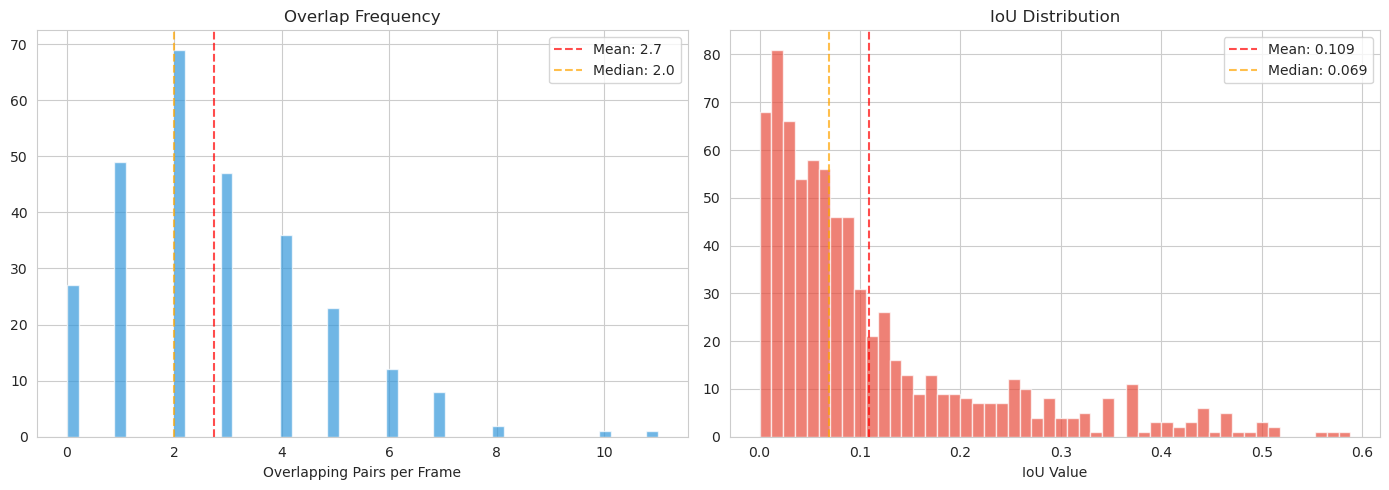

Analyzed 275 frames, found 752 overlaps
Overlaps per frame: mean=2.7, max=11
IoU: mean=0.109, median=0.069
IoU percentiles: 50th=0.069, 75th=0.137, 95th=0.371


In [13]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    
    return intersection / union if union > 0 else 0.0

ann_index = defaultdict(list)
for ann in coco_data['annotations']:
    ann_index[ann['image_id']].append(ann)

sample_size = min(5000, len(ann_index))
sampled_ids = np.random.choice(list(ann_index.keys()), sample_size, replace=False)

overlaps_per_frame = []
iou_values = []

for img_id in sampled_ids:
    anns = ann_index[img_id]
    if len(anns) < 2:
        overlaps_per_frame.append(0)
        continue
    
    bboxes = [ann['bbox'] for ann in anns]
    frame_overlaps = 0
    
    for i in range(len(bboxes)):
        for j in range(i + 1, len(bboxes)):
            iou = calculate_iou(bboxes[i], bboxes[j])
            if iou > 0:
                frame_overlaps += 1
                iou_values.append(iou)
    
    overlaps_per_frame.append(frame_overlaps)

overlaps_per_frame = np.array(overlaps_per_frame)
iou_values = np.array(iou_values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(overlaps_per_frame, bins=50, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(overlaps_per_frame), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(overlaps_per_frame):.1f}')
axes[0].axvline(np.median(overlaps_per_frame), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(overlaps_per_frame):.1f}')
axes[0].set_xlabel('Overlapping Pairs per Frame')
axes[0].set_title('Overlap Frequency')
axes[0].legend()

if len(iou_values) > 0:
    axes[1].hist(iou_values, bins=50, alpha=0.7, color='#e74c3c')
    axes[1].axvline(np.mean(iou_values), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(iou_values):.3f}')
    axes[1].axvline(np.median(iou_values), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(iou_values):.3f}')
    axes[1].set_xlabel('IoU Value')
    axes[1].set_title('IoU Distribution')
    axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Analyzed {sample_size} frames, found {len(iou_values):,} overlaps")
print(f"Overlaps per frame: mean={np.mean(overlaps_per_frame):.1f}, max={np.max(overlaps_per_frame)}")
if len(iou_values) > 0:
    print(f"IoU: mean={np.mean(iou_values):.3f}, median={np.median(iou_values):.3f}")
    print(f"IoU percentiles: 50th={np.percentile(iou_values, 50):.3f}, 75th={np.percentile(iou_values, 75):.3f}, 95th={np.percentile(iou_values, 95):.3f}")

#### Зато пересечений почти в 2 раза меньше, хотя и боксы тоже в среднем в 2 раза меньше

## 6. Objects per Image Analysis

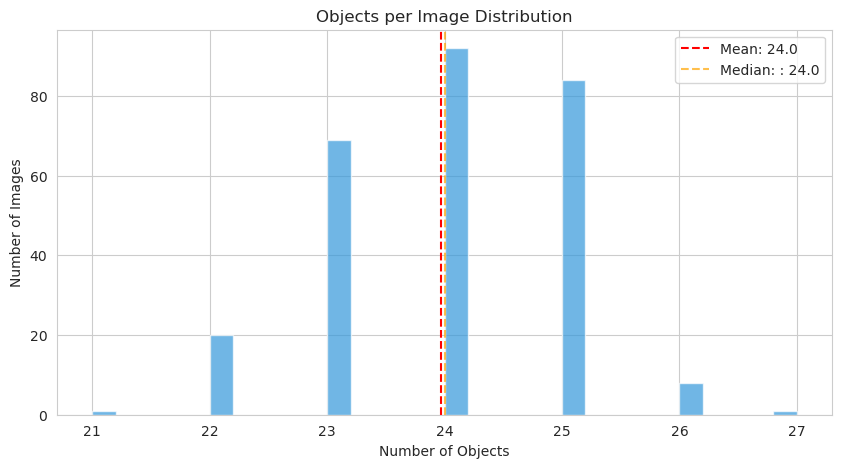

Objects per image: mean=24.0, median=24, max=27


In [14]:
objects_per_image = defaultdict(int)
for ann in coco_data['annotations']:
    objects_per_image[ann['image_id']] += 1

obj_counts = list(objects_per_image.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(obj_counts, bins=30, alpha=0.7, color='#3498db')
ax.axvline(np.mean(obj_counts), color='red', linestyle='--', label=f'Mean: {np.mean(obj_counts):.1f}')
ax.axvline(np.median(obj_counts), color='orange', linestyle='--', alpha=0.7, label=f'Median: : {np.mean(obj_counts):.1f}')
ax.set_xlabel('Number of Objects')
ax.set_ylabel('Number of Images')
ax.set_title('Objects per Image Distribution')
ax.legend()
plt.show()

print(f"Objects per image: mean={np.mean(obj_counts):.1f}, median={np.median(obj_counts):.0f}, max={np.max(obj_counts)}")

#### Вот и ответ на вопрос о размерах боксов: тут мы в среднем видим больше игроков, (11+11+2+1), то есть расстояние съемки больше

## 7. Visualization Helper Functions


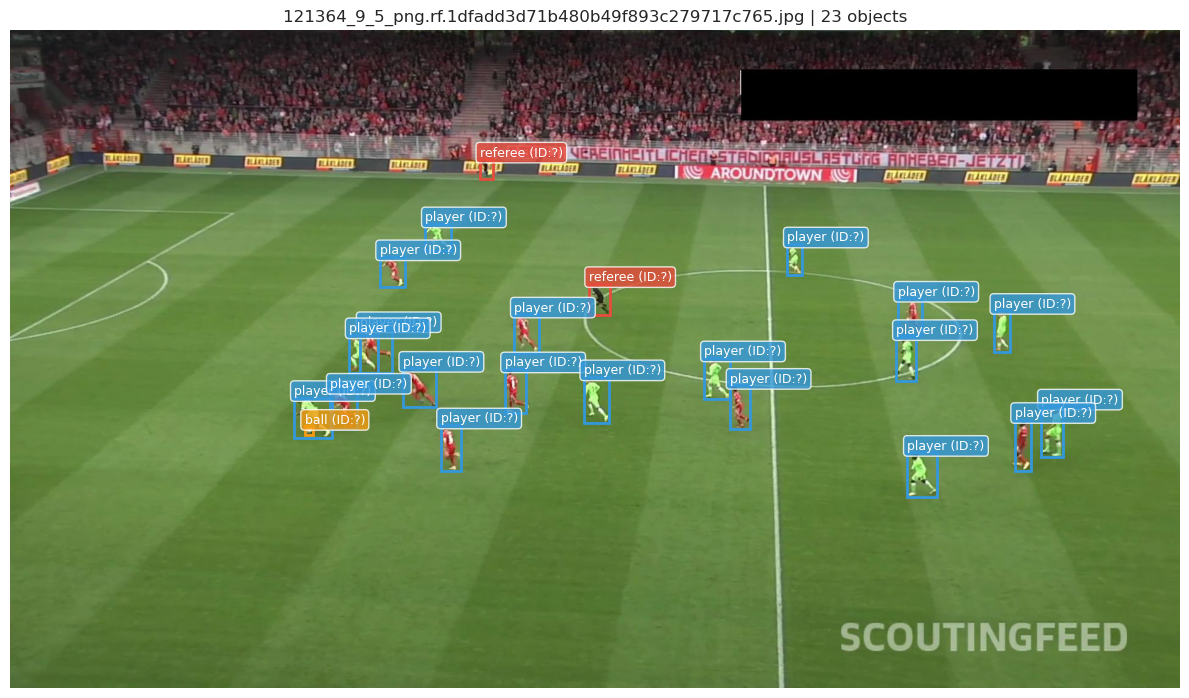

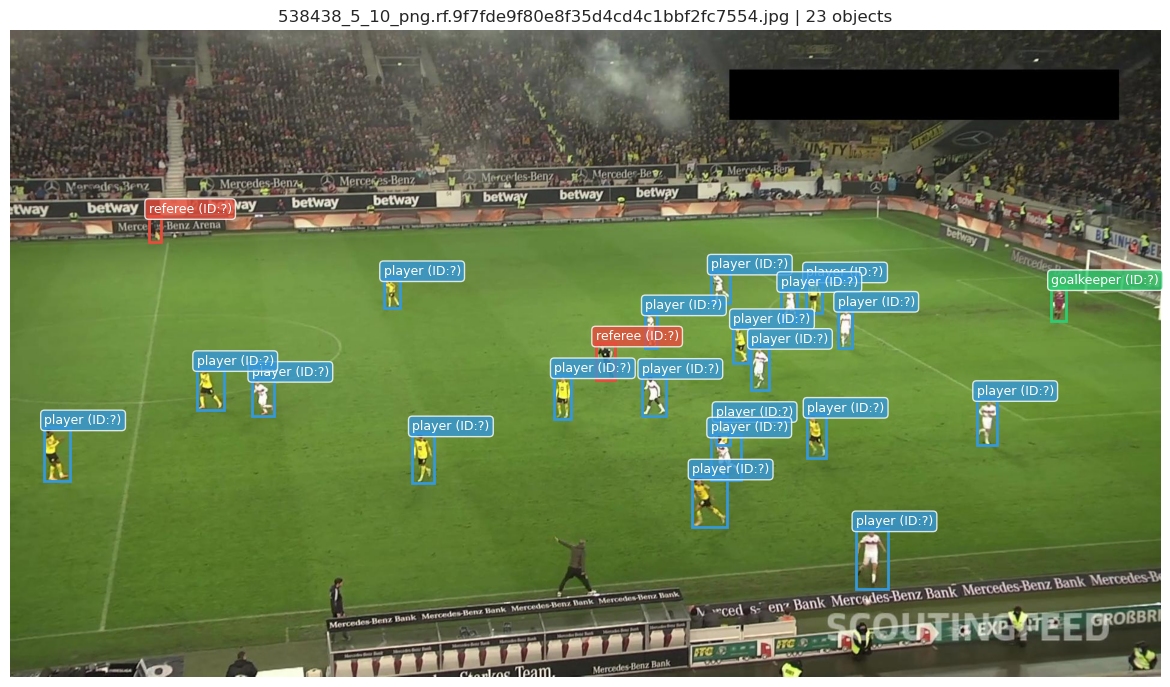

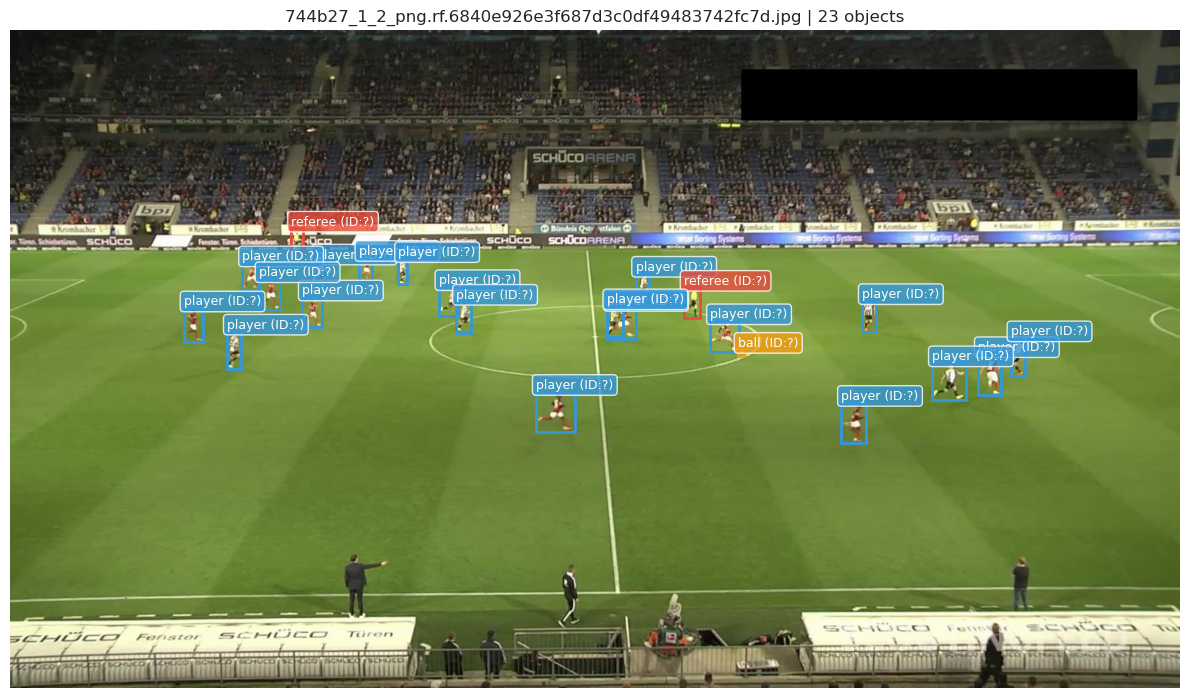

In [15]:
def visualize_image_with_annotations(image_info, annotations, img_dir, category_names, split='train'):
    # Path structure: img_dir / split / 'data' / filename
    img_path = img_dir.parent / split / 'data' / image_info['file_name']
    
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    colors = {1: '#3498db', 2: '#2ecc71', 3: '#e74c3c', 4: '#f39c12'}
    
    for ann in annotations:
        bbox = ann['bbox']
        cat_id = ann['category_id']
        
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                linewidth=2, edgecolor=colors.get(cat_id, 'yellow'), facecolor='none')
        ax.add_patch(rect)
        
        label = f"{category_names[cat_id]} (ID:{ann.get('track_id', '?')})"
        ax.text(bbox[0], bbox[1]-5, label, color='white', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor=colors.get(cat_id, 'yellow'), alpha=0.8))
    
    ax.axis('off')
    ax.set_title(f"{image_info['file_name']} | {len(annotations)} objects")
    plt.tight_layout()
    plt.show()

## 8. Sample Image Visualization
np.random.seed(42)

ann_index = defaultdict(list)
for ann in coco_data['annotations']:
    ann_index[ann['image_id']].append(ann)

images_with_anns = [img for img in coco_data['images'] if img['id'] in ann_index]
sample_images = np.random.choice(images_with_anns, 3, replace=False)

split = 'train'  # Change to 'valid' or 'test'

for img_info in sample_images:
    img_anns = ann_index[img_info['id']]
    visualize_image_with_annotations(img_info, img_anns, img_dir, category_names, split=split)

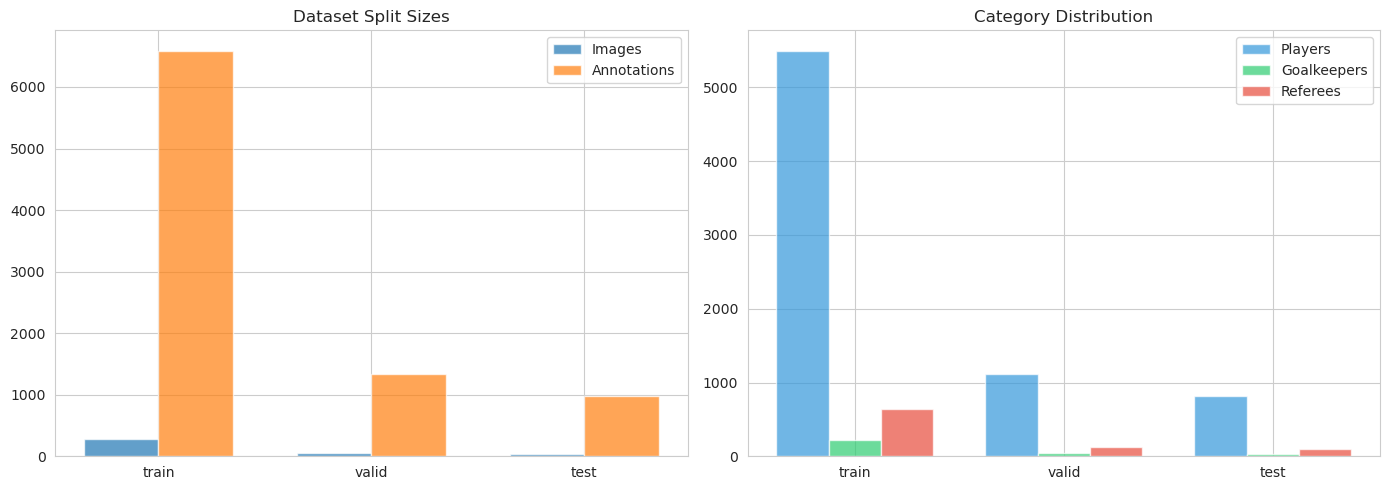

train: 275 imgs, 6,591 anns (P:5,499 GK:215 R:637), 24.0 obj/img
valid: 56 imgs, 1,339 anns (P:1,112 GK:44 R:131), 23.9 obj/img
test: 41 imgs, 976 anns (P:817 GK:29 R:95), 23.8 obj/img


In [16]:
split_stats = {}

for split_name, split_data in datasets.items():
    n_images = len(split_data['images'])
    n_annotations = len(split_data['annotations'])
    cat_counts = Counter([ann['category_id'] for ann in split_data['annotations']])
    
    obj_per_img = defaultdict(int)
    for ann in split_data['annotations']:
        obj_per_img[ann['image_id']] += 1
    
    split_stats[split_name] = {
        'images': n_images,
        'annotations': n_annotations,
        'players': cat_counts.get(1, 0),
        'goalkeepers': cat_counts.get(2, 0),
        'referees': cat_counts.get(3, 0),
        'avg_per_img': np.mean(list(obj_per_img.values()))
    }

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
splits = ['train', 'valid', 'test']

ax = axes[0]
x = np.arange(len(splits))
width = 0.35
images = [split_stats[s]['images'] for s in splits]
anns = [split_stats[s]['annotations'] for s in splits]  # scale for visibility
ax.bar(x - width/2, images, width, label='Images', alpha=0.7)
ax.bar(x + width/2, anns, width, label='Annotations', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_title('Dataset Split Sizes')
ax.legend()

ax = axes[1]
width = 0.25
players = [split_stats[s]['players'] for s in splits]
gk = [split_stats[s]['goalkeepers'] for s in splits]
refs = [split_stats[s]['referees'] for s in splits]
ax.bar(x - width, players, width, label='Players', color='#3498db', alpha=0.7)
ax.bar(x, gk, width, label='Goalkeepers', color='#2ecc71', alpha=0.7)
ax.bar(x + width, refs, width, label='Referees', color='#e74c3c', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_title('Category Distribution')
ax.legend()

plt.tight_layout()
plt.show()

for split in splits:
    s = split_stats[split]
    print(f"{split}: {s['images']:,} imgs, {s['annotations']:,} anns (P:{s['players']:,} GK:{s['goalkeepers']:,} R:{s['referees']:,}), {s['avg_per_img']:.1f} obj/img")

In [17]:
sample_ids = sorted([img['id'] for img in coco_data['images']])[:10]
print(f"Sample image IDs: {sample_ids}")
print(f"Total images: {len(coco_data['images'])}")

Sample image IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total images: 275


Image ID 39: 2e57b9_1_9_png.rf.ec1cf9520bb7eb32ad28b91a739787a0.jpg (25 annotations)


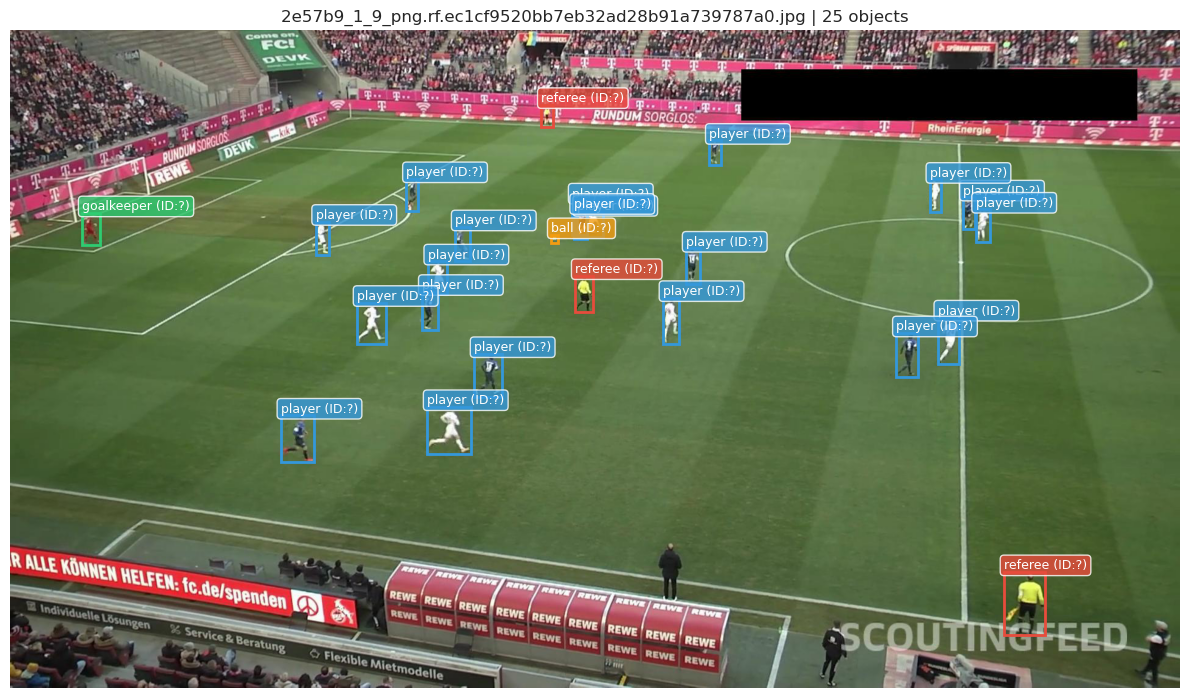

In [18]:
selected_image_id = 39

selected_img = next((img for img in coco_data['images'] if img['id'] == selected_image_id), None)

if selected_img:
    if 'ann_index' not in locals():
        ann_index = defaultdict(list)
        for ann in coco_data['annotations']:
            ann_index[ann['image_id']].append(ann)
    
    selected_anns = ann_index.get(selected_image_id, [])
    print(f"Image ID {selected_image_id}: {selected_img['file_name']} ({len(selected_anns)} annotations)")
    visualize_image_with_annotations(selected_img, selected_anns, img_dir, category_names)
else:
    print(f"Image ID {selected_image_id} not found")

#### В принципе, хороший датасет, беглый просмотр показал качественную разметку, ракурсы еще более телевизионные, жаль только, что данных мало. Интересно, как будет переноситься обучение с этого датасета на soccernet/sportsmot и обратно